In [144]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from collections import namedtuple, defaultdict
from paper_sims_util import MCC
from running_wrappers import get_loaders
import matplotlib.pyplot as plt
%matplotlib inline
LOADERS = get_loaders()
AlgoParams = namedtuple('AlgoParams', 'stability_samples M pi')
GraphParams = namedtuple('GraphParams', 'N eta p d ratios')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [90]:
run_name = 'testrunsmallp'
run_ids = range(3)
graph_type = 'random'

In [91]:
with open("{}_algo_params.pkl".format(run_name), 'rb') as f:
    algo_params = pickle.load(f)
with open("{}_graph_params_dict.pkl".format(run_name), 'rb') as f:
    graph_params_dict = pickle.load(f)

In [149]:
graph_params_dict = {
    'chain': GraphParams(p=20, N=[20, 25, 30, 35, 40], eta=1, ratios=None, d=None), #p, N, eta
    'star': GraphParams(p=20, d=[10, 15, 20, 25, 30], N=50, eta=1, ratios=None), #p, d, N, eta
    'random': GraphParams(p=20, d=0.01, ratios=[r/500. for r in [300, 375, 500, 750, 1000]], eta=1, N=None), #p, d, ratio over 500, eta
    'grid_3D': GraphParams(p=2, ratios=[r/524. for r in [200, 250, 300, 400, 500]], eta=2, N=None, d=None), #p, ratio over 524, eta
    'grid': GraphParams(p=3, ratios=[r/529. for r in [75, 100, 150, 200, 250]], eta=2, N=None, d=None) #p, ratio over 529, eta
}

In [150]:
loaded_data = LOADERS[graph_type](graph_params_dict[graph_type], 
                                  algo_params, 
                                  run_name,
                                  run_ids)

In [168]:
def get_points(loaded_data):
    points = defaultdict(lambda: defaultdict(list))
    for x_label, trials in loaded_data.items(): #x_;
        print(x_label)
        for trial in trials:
            omega = trial[0]
            print(np.sum(omega))
            results = trial[1]
            for algo_name, algo_results in results.items():
                omega_hat = algo_results[0]
                print(algo_name, np.sum(omega_hat))
                algo_mcc = MCC(omega_hat, omega)
                points[algo_name][x_label].append(algo_mcc)
    return points

In [169]:
def plot_lines(d):
    lines = defaultdict(list)
    x_labels = list(next(iter(d.values())).keys())
    for algo_name, x_label_to_trials in d.items():
        for x_label in x_labels:
            trial_MCCs = x_label_to_trials[x_label]
            lines[algo_name].append(np.mean(trial_MCCs))
    return x_labels, lines

In [170]:
points = get_points(loaded_data)

12
19.111111111111107
our 24.0
SH 16.0
glasso 10.0
nbsel 38.0
anand 156.0
19.111111111111107
our 24.0
SH 16.0
glasso 10.0
nbsel 38.0
anand 156.0
19.111111111111107
our 24.0
SH 16.0
glasso 10.0
nbsel 38.0
anand 156.0
15
19.111111111111107
our 26.0
SH 18.0
glasso 18.0
nbsel 48.0
anand 158.0
19.111111111111107
our 26.0
SH 18.0
glasso 18.0
nbsel 48.0
anand 158.0
19.111111111111107
our 26.0
SH 18.0
glasso 18.0
nbsel 48.0
anand 158.0
20
19.111111111111107
our 32.0
SH 26.0
glasso 22.0
nbsel 76.0
anand 168.0
19.111111111111107
our 32.0
SH 26.0
glasso 22.0
nbsel 76.0
anand 168.0
19.111111111111107
our 32.0
SH 26.0
glasso 22.0
nbsel 76.0
anand 168.0
30
18.809023911768442
our 30.0
SH 48.0
glasso 20.0
nbsel 112.0
anand 154.0
18.809023911768442
our 30.0
SH 48.0
glasso 20.0
nbsel 112.0
anand 154.0
18.809023911768442
our 30.0
SH 48.0
glasso 20.0
nbsel 112.0
anand 154.0
40
16.340785729995506
our 32.0
SH 44.0
glasso 136.0
nbsel 114.0
anand 180.0
16.340785729995506
our 32.0
SH 44.0
glasso 136.0
nbsel 11

In [154]:
lines = plot_lines(points)

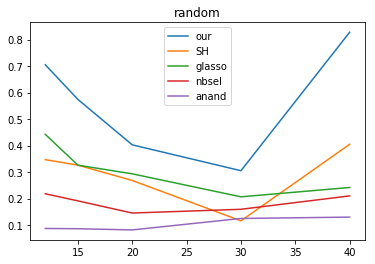

In [155]:
for algo, line in lines[1].items():
    plt.plot(lines[0], line, label=algo)
plt.title(graph_type)
plt.legend()
plt.show()